In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import zipfile

with zipfile.ZipFile('../input/facial-keypoints-detection/training.zip', 'r') as zip_ref:
    with zip_ref.open('training.csv') as file:
        train_df = pd.read_csv(file)


with zipfile.ZipFile('../input/facial-keypoints-detection/test.zip', 'r') as zip_ref:
    with zip_ref.open('test.csv') as file:
        test_df = pd.read_csv(file)


print(f'train shape {train_df.shape}, test shape {test_df.shape}')

train shape (7049, 31), test shape (1783, 2)


In [3]:
train_df.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

In [4]:
all_df = pd.concat([train_df, test_df], axis=0)
print(f'df_all shape {all_df.shape}')

df_all shape (8832, 32)


In [5]:
train_df.Image = train_df.Image.apply(lambda imgSt: np.array(imgSt.split(), dtype=np.uint8).reshape((96, 96, 1)))

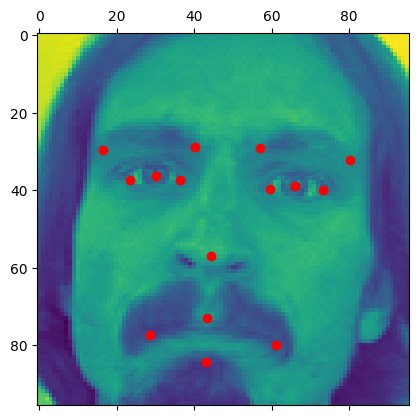

In [6]:
ind = 0
img = train_df.Image[ind]

plt.matshow(img)

for x, y in train_df.iloc[ind].drop('Image').values.reshape((-1, 2)):
    if x  and y:
        plt.scatter(x,y, color='red')

plt.show()

## Train and test set split

In [7]:
X = np.stack(train_df['Image'].values)
y = train_df.drop('Image', axis=1).values

In [8]:
y = y/96.0

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=42)

In [10]:
print(len(X_train), len(X_test))

5991 1058


## Model

In [11]:
def masked_mse_loss(y_true, y_pred):
    mask = tf.math.is_nan(y_true)
    y_true_masked = tf.boolean_mask(y_true, ~mask)
    y_pred_masked = tf.boolean_mask(y_pred, ~mask)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true_masked - y_pred_masked)))
    
def masked_mse_metrics(y_true, y_pred):
    mask = tf.math.is_nan(y_true)
    y_true_masked = tf.boolean_mask(y_true, ~mask)
    y_pred_masked = tf.boolean_mask(y_pred, ~mask)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true_masked - y_pred_masked)*96.0))

model = keras.Sequential([
    keras.Input((96, 96, 1)),
    
    layers.Rescaling(1./255),
    
    layers.Conv2D(8, kernel_size=(5, 5), activation='relu'),
    layers.MaxPool2D(strides=(2, 2)),
    
    layers.Conv2D(8, kernel_size=(5, 5), activation='relu'),
    layers.MaxPool2D(strides=(2, 2)),
    
    layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    layers.MaxPool2D(strides=(2, 2)),
    
    layers.Conv2D(128, kernel_size=(5, 5), activation='relu'),
    layers.MaxPool2D(strides=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(30, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss= masked_mse_loss,
    metrics=[masked_mse_metrics]
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=10,
    min_delta = 0.0005,
    restore_best_weights=True
)
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[early_stopping])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 92, 92, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 8)      │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        51,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,142 (356.02 KB)

 Trainable params: 91,142 (356.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1726924951.073169      65 service.cc:145] XLA service 0x78f2f4001840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726924951.073228      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 39/188 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1269 - masked_mse_metrics: 1.2429

I0000 00:00:1726924954.515838      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0785 - masked_mse_metrics: 0.7688 - val_loss: 0.0399 - val_masked_mse_metrics: 0.3926
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0404 - masked_mse_metrics: 0.3957 - val_loss: 0.0404 - val_masked_mse_metrics: 0.3979
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0398 - masked_mse_metrics: 0.3903 - val_loss: 0.0389 - val_masked_mse_metrics: 0.3834
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0396 - masked_mse_metrics: 0.3878 - val_loss: 0.0357 - val_masked_mse_metrics: 0.3509
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0363 - masked_mse_metrics: 0.3553 - val_loss: 0.0342 - val_masked_mse_metrics: 0.3366
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0329 - masked_mse_metrics: 0.3219 - val_loss: 0.0312 - val_masked_mse_metrics: 0.3059
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0301 - masked_mse_metrics: 0.2951 - val_loss: 0.0289 -

## Predictions

In [12]:
pred = model.predict(X_test).reshape(len(X_test),-1, 2)*96.0
y_true = y_test.reshape(len(y_test), -1, 2)*96.0

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


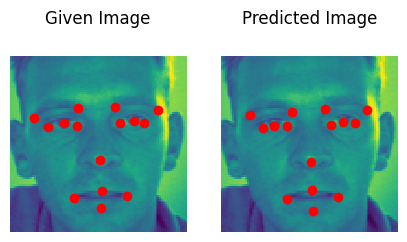

In [13]:
ind = 336

fig, axs = plt.subplots(1, 2, figsize=(5, 5))

axs[0].matshow(X_test[ind])
axs[0].axis('off')
for x, y in y_true[ind]:
    if x  and y:
        axs[0].scatter(x,y, color='red')
axs[0].set_title('Given Image')
        
axs[1].matshow(X_test[ind])
axs[1].axis('off')
for x, y in pred[ind]:
    if x  and y:
        axs[1].scatter(x,y, color='red')
axs[1].set_title('Predicted Image')

plt.show()

## Submission

In [14]:
mydict = {}
for ind, feature in enumerate(train_df.drop('Image', axis=1).columns):
    mydict[feature] = ind

In [15]:
test_df.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [16]:
idloop = pd.read_csv('../input/facial-keypoints-detection/IdLookupTable.csv')
idloop.FeatureName = idloop.FeatureName.apply(lambda feature: mydict[feature])

In [17]:
idloop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27124 entries, 0 to 27123
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RowId        27124 non-null  int64  
 1   ImageId      27124 non-null  int64  
 2   FeatureName  27124 non-null  int64  
 3   Location     0 non-null      float64
dtypes: float64(1), int64(3)
memory usage: 847.8 KB


In [18]:
idloop.columns

Index(['RowId', 'ImageId', 'FeatureName', 'Location'], dtype='object')

In [19]:
test = np.stack(test_df.Image.apply(lambda imgSt: np.array(imgSt.split(), dtype=np.uint8).reshape((96, 96, 1))).values)

In [20]:
test_predict = model.predict(test)*96.0

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [21]:
test_predict.shape

(1783, 30)

In [22]:
test_predict[0][1]

35.01247

In [23]:
idloop.head()

,RowId,ImageId,FeatureName,Location
0,1,1,0,NaN
1,2,1,1,NaN
2,3,1,2,NaN
3,4,1,3,NaN
4,5,1,4,NaN


In [24]:
idloop.Location = [round(test_predict[idloop.ImageId.iloc[i]-1][idloop.FeatureName.iloc[i]])  for i in range(len(idloop))]
idloop.head()

,RowId,ImageId,FeatureName,Location
0,1,1,0,68
1,2,1,1,35
2,3,1,2,30
3,4,1,3,36
4,5,1,4,62


In [25]:
submission = idloop[['RowId', 'Location']].copy()
submission.Location = submission.Location.astype('int64')

In [26]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27124 entries, 0 to 27123
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   RowId     27124 non-null  int64
 1   Location  27124 non-null  int64
dtypes: int64(2)
memory usage: 423.9 KB


In [27]:
submission.to_csv('submission.csv', index=False)

In [28]:
submission.head()

,RowId,Location
0,1,68
1,2,35
2,3,30
3,4,36
4,5,62
